In [1]:
import sys
sys.path.append("..")

from datetime import datetime
import numpy as np
import ujson as json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from lib.dataclasses import SignalDCT, SignalTime, SingleSample, Sample, SignalSpectrum
from lib.utils import get_sample_from_json

In [2]:
plt.style.use('ggplot')
from matplotlib.gridspec import GridSpec

Variables

In [3]:
PATH_TO_DATASET_1 = "/workspaces/project/raw/sequence_1/"
PATH_TO_DATASET_2 = "/workspaces/project/raw/sequence_2/"

# Importing data

In [4]:
sample_list = []
for file_path in tqdm(os.listdir(PATH_TO_DATASET_1)):
    sample_id = file_path.split(".json")[0]
    sample = get_sample_from_json(
        path = PATH_TO_DATASET_1 + file_path,
        sample_id=sample_id
    )
    sample_list.append(sample)

100%|██████████| 2865/2865 [01:30<00:00, 31.66it/s]


In [7]:
def get_band_data(x:list, window:int, fun:str="mean") -> list:
    N = len(x)
    assert N % window == 0

    functions = {
        "mean": lambda x: x.mean(axis=1),
        "max": lambda x: x.max(axis=1),
        "min": lambda x: x.min(axis=1),
        "abs-mean": lambda x: np.abs(x).mean(axis=1),
        "abs-median": lambda x: np.median(np.abs(x), axis=1)
    }

    x = np.array(x)
    x = x.reshape(-1, window)
    x = functions[fun](x)
    return list(x)


In [17]:
tensions = [sample.sample_c1.tension for sample in sample_list]
dates = [sample.sampled_at for sample in sample_list]
dct_1 = np.array([get_band_data(sample[0]["y"].get()[1], window=64, fun="abs-mean") for sample in sample_list])
dct_2 = np.array([get_band_data(sample[1]["y"].get()[1], window=64, fun="abs-mean") for sample in sample_list])
dct_3 = np.array([get_band_data(sample[2]["y"].get()[1], window=64, fun="abs-mean") for sample in sample_list])
dct_4 = np.array([get_band_data(sample[3]["y"].get()[1], window=64, fun="abs-mean") for sample in sample_list])

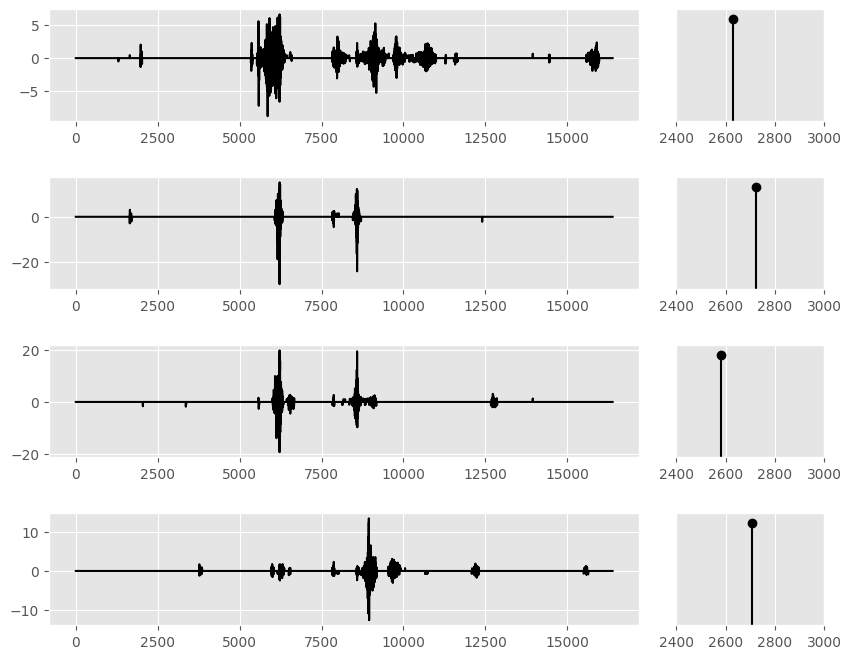

In [18]:
def plot_bar(x, x_min, x_max, ax):
    ax.plot([x,x], [-1,1], marker='o', color='k')
    ax.set_xlim([x_min, x_max])
    ax.set_yticks([])
    ax.set_ylim([0,1.1])    

spec = GridSpec(
    ncols=2, nrows=4,
    width_ratios=[4, 1], wspace=0.1, 
    hspace=0.5, height_ratios=[1, 1, 1, 1]
)

sample = sample_list[100]

t_min = 2400
t_max = 3000

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(spec[0])
x = sample[0]["y"].get()[1]
t = sample[0].tension
ax.plot(x, color='k')
ax = fig.add_subplot(spec[1])
plot_bar(t, t_min, t_max, ax)

ax = fig.add_subplot(spec[2])
x = sample[1]["y"].get()[1]
t = sample[1].tension
ax.plot(x, color='k')
ax = fig.add_subplot(spec[3])
plot_bar(t, t_min, t_max, ax)

ax = fig.add_subplot(spec[4])
x = sample[2]["y"].get()[1]
t = sample[2].tension
ax.plot(x, color='k')
ax = fig.add_subplot(spec[5])
plot_bar(t, t_min, t_max, ax)

ax = fig.add_subplot(spec[6])
x = sample[3]["y"].get()[1]
t = sample[3].tension
ax.plot(x, color='k')
ax = fig.add_subplot(spec[7])
plot_bar(t, t_min, t_max, ax)

In [22]:
dct_1.shape[1]

256

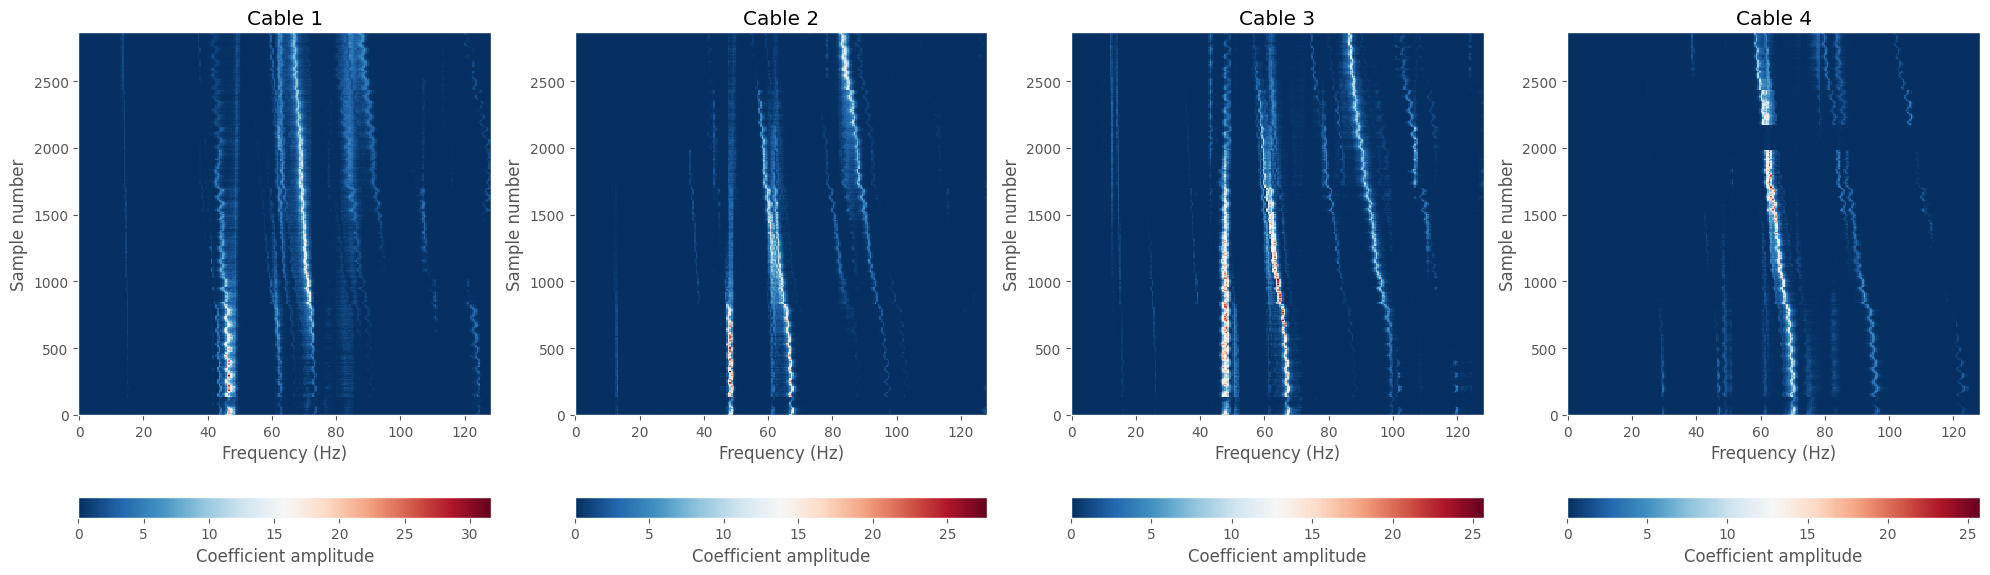

In [41]:
min_x = 0
max_x = len(tensions)

f = np.linspace(0, 128, dct_1.shape[1])
t = np.linspace(0, dct_1.shape[0], dct_1.shape[0])

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,4,1)
ax.set_title("Cable 1")
pc = ax.pcolormesh(f, t, np.abs(dct_1), cmap="RdBu_r")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Sample number")
fig.colorbar(pc, location="bottom", label="Coefficient amplitude")

ax = fig.add_subplot(1,4,2)
ax.set_title("Cable 2")
pc = ax.pcolormesh(f, t, np.abs(dct_2), cmap="RdBu_r")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Sample number")
fig.colorbar(pc, location="bottom", label="Coefficient amplitude")

ax = fig.add_subplot(1,4,3)
ax.set_title("Cable 3")
pc = ax.pcolormesh(f, t, np.abs(dct_3), cmap="RdBu_r")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Sample number")
fig.colorbar(pc, location="bottom", label="Coefficient amplitude")

ax = fig.add_subplot(1,4,4)
ax.set_title("Cable 4")
pc = ax.pcolormesh(f, t, np.abs(dct_4), cmap="RdBu_r")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Sample number")
fig.colorbar(pc, location="bottom", label="Coefficient amplitude")

fig.tight_layout()